In [9]:
%matplotlib widget
%load_ext line_profiler
import raster_geometry as rg
import numpy as np
from scipy import spatial, stats
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm
import cupy as cp
import flyingcircus as fc
import flyingcircus_numeric as fcn

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


array([[0., 0.],
       [0., 0.]])

In [53]:
def test_superellipsoid(
        shape,
        semisizes=0.5,
        indexes=2,
        position=0.5,
        n_dim=None,
        rel_position=True,
        rel_sizes=True,
        smoothing=False):
    """
    Render an N-dim superellipsoid.
    The cartesian equations are:
    .. math::
        \\sum[\\abs(\\frac{x_n}{a_n})^{k_n}] < 1.0
    where :math:`n` runs through the dims, :math:`x` are the cartesian
    coordinate, :math:`a` are the semi-sizes (semi-axes) and
    :math:`k` are the indexes.
    When the index is 2, an ellipsoid (hyperellipsoid) is generated.
    Args:
        shape (int|Sequence[int]): The shape of the container in px.
        semisizes (float|Sequence[float]): The superellipsoid axes semisizes.
            The values interpretation depend on `rel_sizes`.
        position (float|Sequence[float]): The position of the center.
            Values are relative to the lowest edge.
            The values interpretation depend on `rel_position`.
        indexes (float|Sequence[float]): The exponent of the summed terms.
            If 2, generates ellipsoids.
        n_dim (int|None): The number of dimensions.
            If None, the number of dims is guessed from the other parameters,
            but one of `shape`, `position`, `semisizes`, `indexes` must be
            Sequence.
        rel_position (bool|callable): Interpret positions as relative values.
            Determine the interpretation of `position`.
            Uses `flyingcircus.extra.grid_coord()` internally, see its
            `is_relative` parameter for more details.
        rel_sizes (bool|callable): Interpret sizes as relative values.
            Determine the interpretation of `semisizes`.
            Uses `flyingcircus_numeric.coord()` internally, see its
            `is_relative` parameter for more details.
        smoothing (bool|int|float): The smoothing of the border.
            If False, no smoothing is performed and the data type of
            the result is bool.
            If int or float, smooths the border transition and the data type of
            the result is float.
            When the value is equal to 1 or True, the smoothing emulates
            the spatial anti-aliasing.
    Returns:
        rendered (np.ndarray[bool|float]): The rendered geometrical object.
            The data type depends on the value and type of smoothing.
    """
    if not n_dim:
        n_dim = fc.combine_iter_len((shape, position, semisizes, indexes))

    # check compatibility of given parameters
    shape = fc.auto_repeat(shape, n_dim, check=True)
    position = fc.auto_repeat(position, n_dim, check=True)
    semisizes = fc.auto_repeat(semisizes, n_dim, check=True)
    indexes = fc.auto_repeat(indexes, n_dim, check=True)

    # get correct position
    semisizes = fcn.coord(
        shape, semisizes, is_relative=rel_sizes, use_int=False)
    # print('Semisizes: {}'.format(semisizes))  # DEBUG
    # print('Shape: {}'.format(shape))  # DEBUG
    xx = fcn.grid_coord(
        shape, position, is_relative=rel_position, use_int=False)
    # print('X: {}'.format(xx))  # DEBUG

    # create the rendered result
    rendered_gpu = cp.zeros(shape, dtype=float)
    for x_i, semisize, index in zip(xx, semisizes, indexes):
        x_i_gpu = cp.asarray(x_i)
        print(semisize)
        rendered_gpu = (cp.abs(x_i_gpu))
    if smoothing is False:
        rendered_gpu = rendered_gpu <= 1.0
    else:
        if smoothing > 0:
            k = fc.prod(semisizes) ** (1 / index / n_dim / smoothing)
            rendered_gpu = np.clip(1.0 - rendered_gpu, 0.0, 1.0 / k) * k
        else:
            rendered_gpu = rendered_gpu.astype(float)
    return cp.asnumpy(rendered_gpu)

In [8]:
# size = (100, 100, 100)
radius = 1
size = 2 * (radius + 1)
# position = (50, 50, 50)

midpoint = [size / 2] * 3
print(midpoint)

# target = rg.nd_superellipsoid(size, radius, position=position, rel_sizes=False, rel_position=False)
print(f"Radius: {radius}, Container size: {size}")
sphere = rg.nd_superellipsoid(size, radius, position=midpoint, rel_sizes=False, rel_position=False).astype(np.int_)
print(sphere)
# sphere = rg.sphere(size, radius, 0.5).astype(np.int_)

[2.0, 2.0, 2.0]
Radius: 1, Container size: 4
[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 1 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 1 0]
  [0 1 1 1]
  [0 0 1 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 1 0]
  [0 0 0 0]]]


In [54]:

%time test_superellipsoid((5,5,5), 2, rel_sizes=False).astype(np.int_)
# %time test_superellipsoid((50,50,50), 2, rel_sizes=False).astype(np.int_)
# %time test_superellipsoid((500,500,500), 2, rel_sizes=False).astype(np.int_)
# %time test_superellipsoid((1000,1000,1000), 2, rel_sizes=False).astype(np.int_)

# %time rg.nd_superellipsoid((1000,1000,1000), 2, rel_sizes=False).astype(np.int_)
# %time rg.nd_superellipsoid((1000,1000,1000), 20, rel_sizes=False).astype(np.int_)
# %time rg.nd_superellipsoid((1000,1000,1000), 200, rel_sizes=False).astype(np.int_)
# %time rg.nd_superellipsoid((1000,1000,1000), 2000, rel_sizes=False).astype(np.int_)

2


FileNotFoundError: [Errno 2] No such file or directory: '/home/dkermany/.local/share/virtualenvs/BoneSegmentation-C6QGg7XR/lib/python3.9/site-packages/cupy/_core/include/cupy/complex/complex.h'

In [10]:
# def draw_sphere_in_volume(volume: np.ndarray, radius: int, position: tuple) -> None:
#     """
#     Draw a sphere in a given 3D NumPy array at a specified position.

#     Args:
#     volume (numpy.ndarray): The 3D NumPy array in which the sphere will be drawn.
#     radius (int): The radius of the sphere.
#     position (tuple): A 3-tuple containing the z, x, y coordinates of the position in the array where the sphere will be drawn.

#     Returns:
#     None
#     """
#     # Create an empty 3D NumPy array with dimensions equal to twice the radius plus one
#     size = 2 * (radius + 1)


#     # Calculate the midpoint of the array
#     midpoint = [size / 2] * 3

#     # Generate the sphere using the rg library's superellipsoid function
#     sphere = rg.nd_superellipsoid(size, radius, position=midpoint,
#                                   rel_sizes=False, rel_position=False).astype(np.int_)

#     # Extract the z, x, and y coordinates of the position where the sphere will be drawn
#     z, x, y = position

#     # Calculate the delta change needed to center the sphere at the specified position
#     d = (size//2)

#     # Calculate the minimum and maximum indices for the z, x, and y axes of the volume array
#     zmin, zmax = max(z - d, 0), min(z + d, volume.shape[0])
#     xmin, xmax = max(x - d, 0), min(x + d, volume.shape[1])
#     ymin, ymax = max(y - d, 0), min(y + d, volume.shape[2])

#     # Calculate the minimum indices for the z, x, and y axes of the sphere array
#     szmin = abs(z - d) if z - d < 0 else 0
#     sxmin = abs(x - d) if x - d < 0 else 0
#     symin = abs(y - d) if y - d < 0 else 0

#     # Calculate the amount to cut off of the ends of the z, x, and y axes of the sphere array
#     szmax = abs(volume.shape[0] - (z + d)) if z + d > volume.shape[0] else 0
#     sxmax = abs(volume.shape[1] - (x + d)) if x + d > volume.shape[2] else 0
#     symax = abs(volume.shape[2] - (y + d)) if y + d > volume.shape[2] else 0

#     # Trim the sphere array to fit within the trimmed volume array
#     sphere = sphere[szmin:sphere.shape[0]-szmax, sxmin:sphere.shape[1]-sxmax, symin:sphere.shape[2]-symax]

#     # Place the sphere within the larger volume array at the specified position
#     volume[zmin:zmax, xmin:xmax, ymin:ymax] = sphere

In [11]:
# volume = np.zeros((10,10,10))

# draw_sphere_in_volume(volume, 12, (0,0,0))

In [12]:
def test_sphere_speed(radius, x):
    # Create an empty 3D NumPy array with dimensions equal to twice the radius plus one
    size = 2 * (radius + 1)

    # Calculate the midpoint of the sphere unit array
    midpoint = [size / 2] * 3

    # Generate a unit sphere using the rg library's superellipsoid function
    sphere = rg.nd_superellipsoid(size, radius, position=midpoint,
                                  rel_sizes=False, rel_position=False).astype(np.int_)

    

In [13]:
import multiprocessing as mp
radii = np.arange(100, 300)
x = np.arange(0, 200)

In [14]:
# %%time 
# for radius in radii:
#     test_sphere_speed(radius)

TypeError: test_sphere_speed() missing 1 required positional argument: 'x'

In [ ]:
%%time
with mp.Pool(32) as pool:
    pool.starmap(test_sphere_speed, zip(radii, x))

CPU times: user 87.8 ms, sys: 133 ms, total: 221 ms
Wall time: 10.1 s


In [ ]:
from scipy import spatial, stats
from functools import reduce

In [15]:
def draw_sphere_in_volume(volume: np.ndarray, radius: int, position: tuple) -> None:
    """
    Draw a sphere in a given 3D NumPy array at a specified position.

    Args:
    volume (numpy.ndarray): The 3D NumPy array in which the sphere will be drawn.
    radius (int): The radius of the sphere.
    position (tuple): A 3-tuple containing the z, y, x coordinates of the position in the array where the sphere will be drawn.

    Returns:
    None
    """
    # Create an empty 3D NumPy array with dimensions equal to twice the radius plus one
    size = 2 * (radius + 1)

    # Calculate the midpoint of the sphere unit array
    midpoint = [size / 2] * 3

    # Generate a unit sphere using the rg library's superellipsoid function
    sphere = rg.nd_superellipsoid(size, radius, position=midpoint,
                                  rel_sizes=False, rel_position=False).astype(np.int_)

    # Extract the z, y, x coordinates of the position where the sphere will be drawn
    z, y, x = map(round, position)

    # Calculate the delta change needed to center the sphere at the specified position
    d = (size//2)

    # Calculate the minimum and maximum indices for the z, y, x axes of the volume array
    # print(position, radius, x-d, x+d, max(x - d, 0), min(x + d, volume.shape[2]))
    zmin, zmax = max(z - d, 0), min(z + d, volume.shape[0])
    ymin, ymax = max(y - d, 0), min(y + d, volume.shape[1])
    xmin, xmax = max(x - d, 0), min(x + d, volume.shape[2])

    # Calculate the minimum indices for the z, y, x axes of the sphere array
    szmin = abs(z - d) if z - d < 0 else 0
    symin = abs(y - d) if y - d < 0 else 0
    sxmin = abs(x - d) if x - d < 0 else 0

    # Calculate the amount to cut off of the ends of the z, y, x axes of the sphere array
    szmax = abs(volume.shape[0] - (z + d)) if z + d > volume.shape[0] else 0
    symax = abs(volume.shape[1] - (y + d)) if y + d > volume.shape[1] else 0
    sxmax = abs(volume.shape[2] - (x + d)) if x + d > volume.shape[2] else 0
    

    # Trim the sphere array to fit within the trimmed volume array
    try:
        sphere = sphere[szmin:sphere.shape[0]-szmax, symin:sphere.shape[1]-symax, sxmin:sphere.shape[2]-sxmax]
    except:
        print("Z", szmin, szmax, "Y", symin, symax, "X", sxmin, sxmax)

    # Place the sphere within the larger volume array at the specified position
    volume[zmin:zmax, ymin:ymax, xmin:xmax] = sphere

In [16]:
class Ripley():
    def __init__(
        self,
        points: np.ndarray,
        radii: list,
        volume_shape: tuple,
        boundary_correction: bool = True
    ):
        self.points = points
        self.radii = radii
        self.volume_shape = volume_shape
        self.boundary_correction = boundary_correction
        self._validate_inputs()

        self.results = {"K": [], "L": [], "H": []}

        self.tree = spatial.cKDTree(self.points)
        self.study_volume = reduce(lambda x, y: x * y, self.volume_shape)

    def run_ripley(self, processes=32):
        with mp.Pool(processes) as pool:
            # pool.map(self._calc_ripley, radii)
            list(tqdm(pool.imap(self._calc_ripley, radii), total=len(radii)))

        # print("done")
        # print(self.results["K"])

    def _validate_inputs(self):
        # Check if self.points is a list or numpy array
        if not isinstance(self.points, (list, np.ndarray)):
            e = f"Expected {np.ndarray}, received {type(self.points)}"
            raise ValueError(e)

        # Convert self.points to numpy array if it is a list
        if not isinstance(self.points, np.ndarray):
            self.points = np.array(self.points)

        # Check if self.points array has two dimensions
        if len(self.points.shape) != 2:
            e = f"Expected self.points array to have 2 dimensions, but got array with shape {self.points.shape}"
            raise ValueError(e)

        # Check if the self.points array second dimension length is 3 (x, y, z)
        if self.points.shape[1] != 3:
            e = f"Expected self.points array to have shape (None, 3), but got array with shape {self.points.shape}"
            raise ValueError(e)

        # Check if the self.points array has at least 3 points
        if self.points.shape[0] < 3:
            e = f"Expected self.points array to have at least 3 points"
            raise ValueError(e)

        # Check if radii is list-like or number-like
        if not isinstance(self.radii, (np.ndarray, list, int, float)):
            e = f"Expected {(np.ndarray, list, int, float)}, received {type(self.radii)}"
            raise ValueError(e)

        # if only one radius given as int, convert to list
        if not isinstance(self.radii, (np.ndarray, list)):
            self.radii = [self.radii]

    def _calc_ripley(self, radius):
        # For each radius, loop through each point and count points
        # within the radius
        nb_count = 0
        for z, y, x in self.points:
            if self.boundary_correction:
                weight = self.calculate_weight(radius, (z, y, x))
                # If weight is zero (i.e. target sphere not in mask), move on
                if weight == 0:
                    continue
            else:
                weight = 1.0

            # query_ball_point() includes the index of the current point as well
            # so 1 is subtracted from the count
            nb_count += (len(self.tree.query_ball_point([z, y, x], radius)) - 1) / weight


        # calculating 3D Ripley's functions (K, L, H)
        N = self.points.shape[0]
        K = nb_count * self.study_volume / (N * (N - 1))
        L = ((3. / 4) * (K / np.pi)) ** (1. / 3)
        H = L - radius
        
        # Verify K/L values positive
        if K < 0 or L < 0:
            raise ValueError(f"K/L values should not be negative. nb_count: {nb_count}, volume: {volume}, N: {N}")

        self.results["K"].append((radius, K))
        self.results["L"].append((radius, L))
        self.results["H"].append((radius, H))

    def calculate_weight(self, radius, center):
        """
        Calculate the proportion of a sphere within a study volume.

        Args:
        radius (int): The radius of the sphere.
        center (tuple): A 3-tuple containing the z, y, x coordinates of the center of the sphere.

        Returns:
        float: The proportion of the sphere within the study volume.
        """
        # Ensure that the radius is greater than zero
        assert radius > 0

        # Draw the target sphere in a 3D NumPy array at the specified position
        target = np.zeros(self.volume_shape)
        draw_sphere_in_volume(target, radius, center)

        # Calculate the sum (volume) of the target and reference sphere arrays
        target = target.sum()

        # Reference is calculated instead of simulated for speed increase
        reference = (4 / 3) * np.pi * (radius ** 3)

        # Ensure that the reference sphere has a non-zero volume
        assert reference > 0

        # Return the proportion of the sphere within the study volume
        # Since target volume is estimated whereas reference volume is calculated,
        # there is a small but noticable margin of error when radius < 10, there
        # we set maxiumum value of 1.0
        return min(target / reference, 1.0)


In [23]:
CSR_data = []
CSR_data_w = []

radii=np.arange(300, 360) 

np.random.seed(69420)
CSR_points = stats.uniform.rvs(0, 100, (100,3))

ripley = Ripley(CSR_points, radii, (100,3000,3000), boundary_correction=True)
ripley.run_ripley(60)


100%|██████████████████████████████████████████████████████████████████████████| 60/60 [20:26<00:00, 20.44s/it]


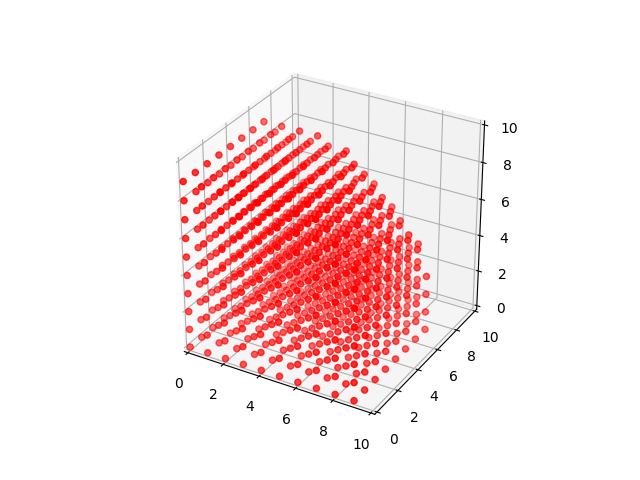

In [14]:
def set_aspect_ratio_equal(ax) -> None:
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    ax.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))

z,x,y = volume.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
set_aspect_ratio_equal(ax)
ax.axes.set_xlim3d(left=0, right=volume.shape[0]) 
ax.axes.set_ylim3d(bottom=0, top=volume.shape[1]) 
ax.axes.set_zlim3d(bottom=0, top=volume.shape[2]) 
ax.scatter(x, y, z, zdir='z', c= 'red')
plt.show()